Import statements

In [157]:
import numpy as np
import pandas as pd
import re
import os
import glob
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors

Load the Data adequately

In [7]:
# the name of our directory
dname = os.path.dirname(os.getcwd()) + "/data_loading/data_v2_quotes/"
dname

'c:\\Users\\Jirko\\Desktop\\Hip_Lab\\analysis_scripts/data_loading/data_v2_quotes/'

In [50]:
# load the data
df = pd.read_csv(dname + "full_data.csv")
# drop redundant columns
df.drop(columns=["trial_bonus", "block_bonus", "resp_indices", "resp_indices_values", "resp_timestamp", "resp_reactiontime"], inplace=True)
df.head(3)

(1280, 16)

In [105]:
# find the subjects
sujs = df['id'].unique()
# select all rows from first block
df_block0 = df.loc[df['expt_block'] == 0] # df.loc[:, df.loc['expt_block'] == 0]
df_block0.shape
# select all rows for our first category
df_block0_cat01 = df_block0.loc[df_block0['vbxi_category'].isin([0, 1])]
df_block0_cat01.head(3)



[0 1 2 3 4 5 6 7 8 9]


,Unnamed: 0,id,expt_index,expt_trial,expt_block,trial_att,vbxi_category,exemplar,trialProperties,trialPropShuff,property_order,resp_correct_array,resp_correct_array_unshuf,prop_responses,groundTruthCorrect,groundTruthCorrect_unshuf
3,3,0,3,3,0,1,0,13,"[1, 1, 0, 1, 0, 0, 0]","[[1, 0, 1, 0, 1, 0, 0], [1, 1, 0, 0, 0, 0, 1]]","[[0, 6, 1, 5, 3, 4, 2], [1, 0, 6, 2, 5, 4, 3]]","[[None, False, None, False, True, None, None],...","[[None, None, None, True, None, False, False],...","[[None, 1, None, 1, 1, None, None], [1, 1, Non...","[[0, 0, 0, 0, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]","[[0, 0, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1]]"
5,5,0,5,5,0,1,1,9,"[1, 1, 0, 1, 0, 0, 0]","[[0, 1, 1, 0, 0, 1, 0], [0, 0, 1, 0, 0, 1, 1]]","[[2, 3, 0, 4, 6, 1, 5], [2, 6, 1, 5, 4, 0, 3]]","[[None, None, None, False, False, True, None],...","[[None, True, None, None, False, None, False],...","[[None, None, None, 1, 1, 1, None], [None, Non...","[[1, 0, 0, 0, 0, 1, 1], [1, 1, 1, 1, 1, 1, 1]]","[[0, 1, 1, 0, 0, 1, 0], [1, 1, 1, 1, 1, 1, 1]]"
7,7,0,7,7,0,0,0,10,"[1, 1, 0, 1, 0, 0, 0]","[[1, 0, 0, 1, 0, 0, 1]]","[[0, 2, 4, 3, 5, 6, 1]]","[[True, None, None, True, None, None, True]]","[[True, True, None, True, None, None, None]]","[[1, None, None, 1, None, None, 1]]","[[1, 1, 1, 1, 1, 1, 1]]","[[1, 1, 1, 1, 1, 1, 1]]"


In [137]:
# get the average response vector in the first block for the first two categories
vec_bl0_cat01 = df_block0_cat01["resp_correct_array_unshuf"]
vec_bl0_cat01 = vec_bl0_cat01.apply(lambda x: np.asarray(literal_eval(x)[0]))
vec_bl0_cat01 = vec_bl0_cat01.apply(lambda x: np.select([x == True, x == False],[1, 1]))
vec_bl0_cat01 =  vec_bl0_cat01.sum(axis=0)/vec_bl0_cat01.shape[0]
print(vec_bl0_cat01)

[0.75       0.67857143 0.21428571 0.58928571 0.28571429 0.26785714
 0.21428571]


In [148]:
def input_output_matrix(df):
    """function to create the input output matrix"""
    
    # get lists of the blocks and categories
    blocks = df['expt_block'].unique()
    categs = (df['vbxi_category'].unique())
    categs.sort()

    # create a 3D tensor to store the category specific performance across blocks
    in_out_matrix = np.full((7, int(len(categs)/2), len(blocks)), np.nan)

    for block in blocks:

        # select block specific part of dataframe
        df_block = df.loc[df['expt_block'] == block]

        for i, categ in enumerate(categs[::2]):
            
            # slightly tedious selection of the relevant cateogries
            df_block_categ = df_block.loc[df_block['vbxi_category'].isin([categ, categ + 1])]
            df_block_categ = df_block_categ["resp_correct_array_unshuf"]

            # change the evaluation as pandas read my lists as strings
            df_block_categ = df_block_categ.apply(lambda x: np.asarray(literal_eval(x)[0]))

            # we change the coding of our data adequatly for storage
            df_block_categ = df_block_categ.apply(lambda x: np.select([x == True, x == False],[1, 1]))

            # get mean array of property responses for each block and category
            array_block_categ = df_block_categ.sum(axis=0)/df_block_categ.shape[0]
            # place the result in our output
            in_out_matrix[:, i, block] = array_block_categ
    
    return in_out_matrix

in_out_matrix = input_output_matrix(df)
np.save(dname + 'in_out_matrix.npy', in_out_matrix)
print(in_out_matrix.shape)

(7, 4, 8)


Now we plot, first we define parameters

In [147]:
cmap = matplotlib.cm.get_cmap('Set1')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

Now we plot

In [180]:
# custom function for the cmap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plot_inout_matrix(in_out_matrix, fig_name, fig_title):
    # Define figure
    fig, axes = plt.subplots(2, 4, figsize=(10, 6), dpi=300, facecolor='w')
    cmap = plt.get_cmap('Reds')
    new_cmap = truncate_colormap(cmap,0, 1)

    # Average per bloc
    for i, ax in enumerate(axes.flatten()):
        im = ax.matshow(in_out_matrix[:,:,i], cmap=new_cmap)
    # Aesthetics
    # ax.set_title(fig_title, fontweight='bold')
    # ax.set_ylim(0.3, 1.05)
    # ax.set_xlabel('Block #')
    # ax.set_ylabel('Accuracy')
    # remove the x and y ticks
    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    # plt.tight_layout()
    
    # fig.savefig(fig_name)

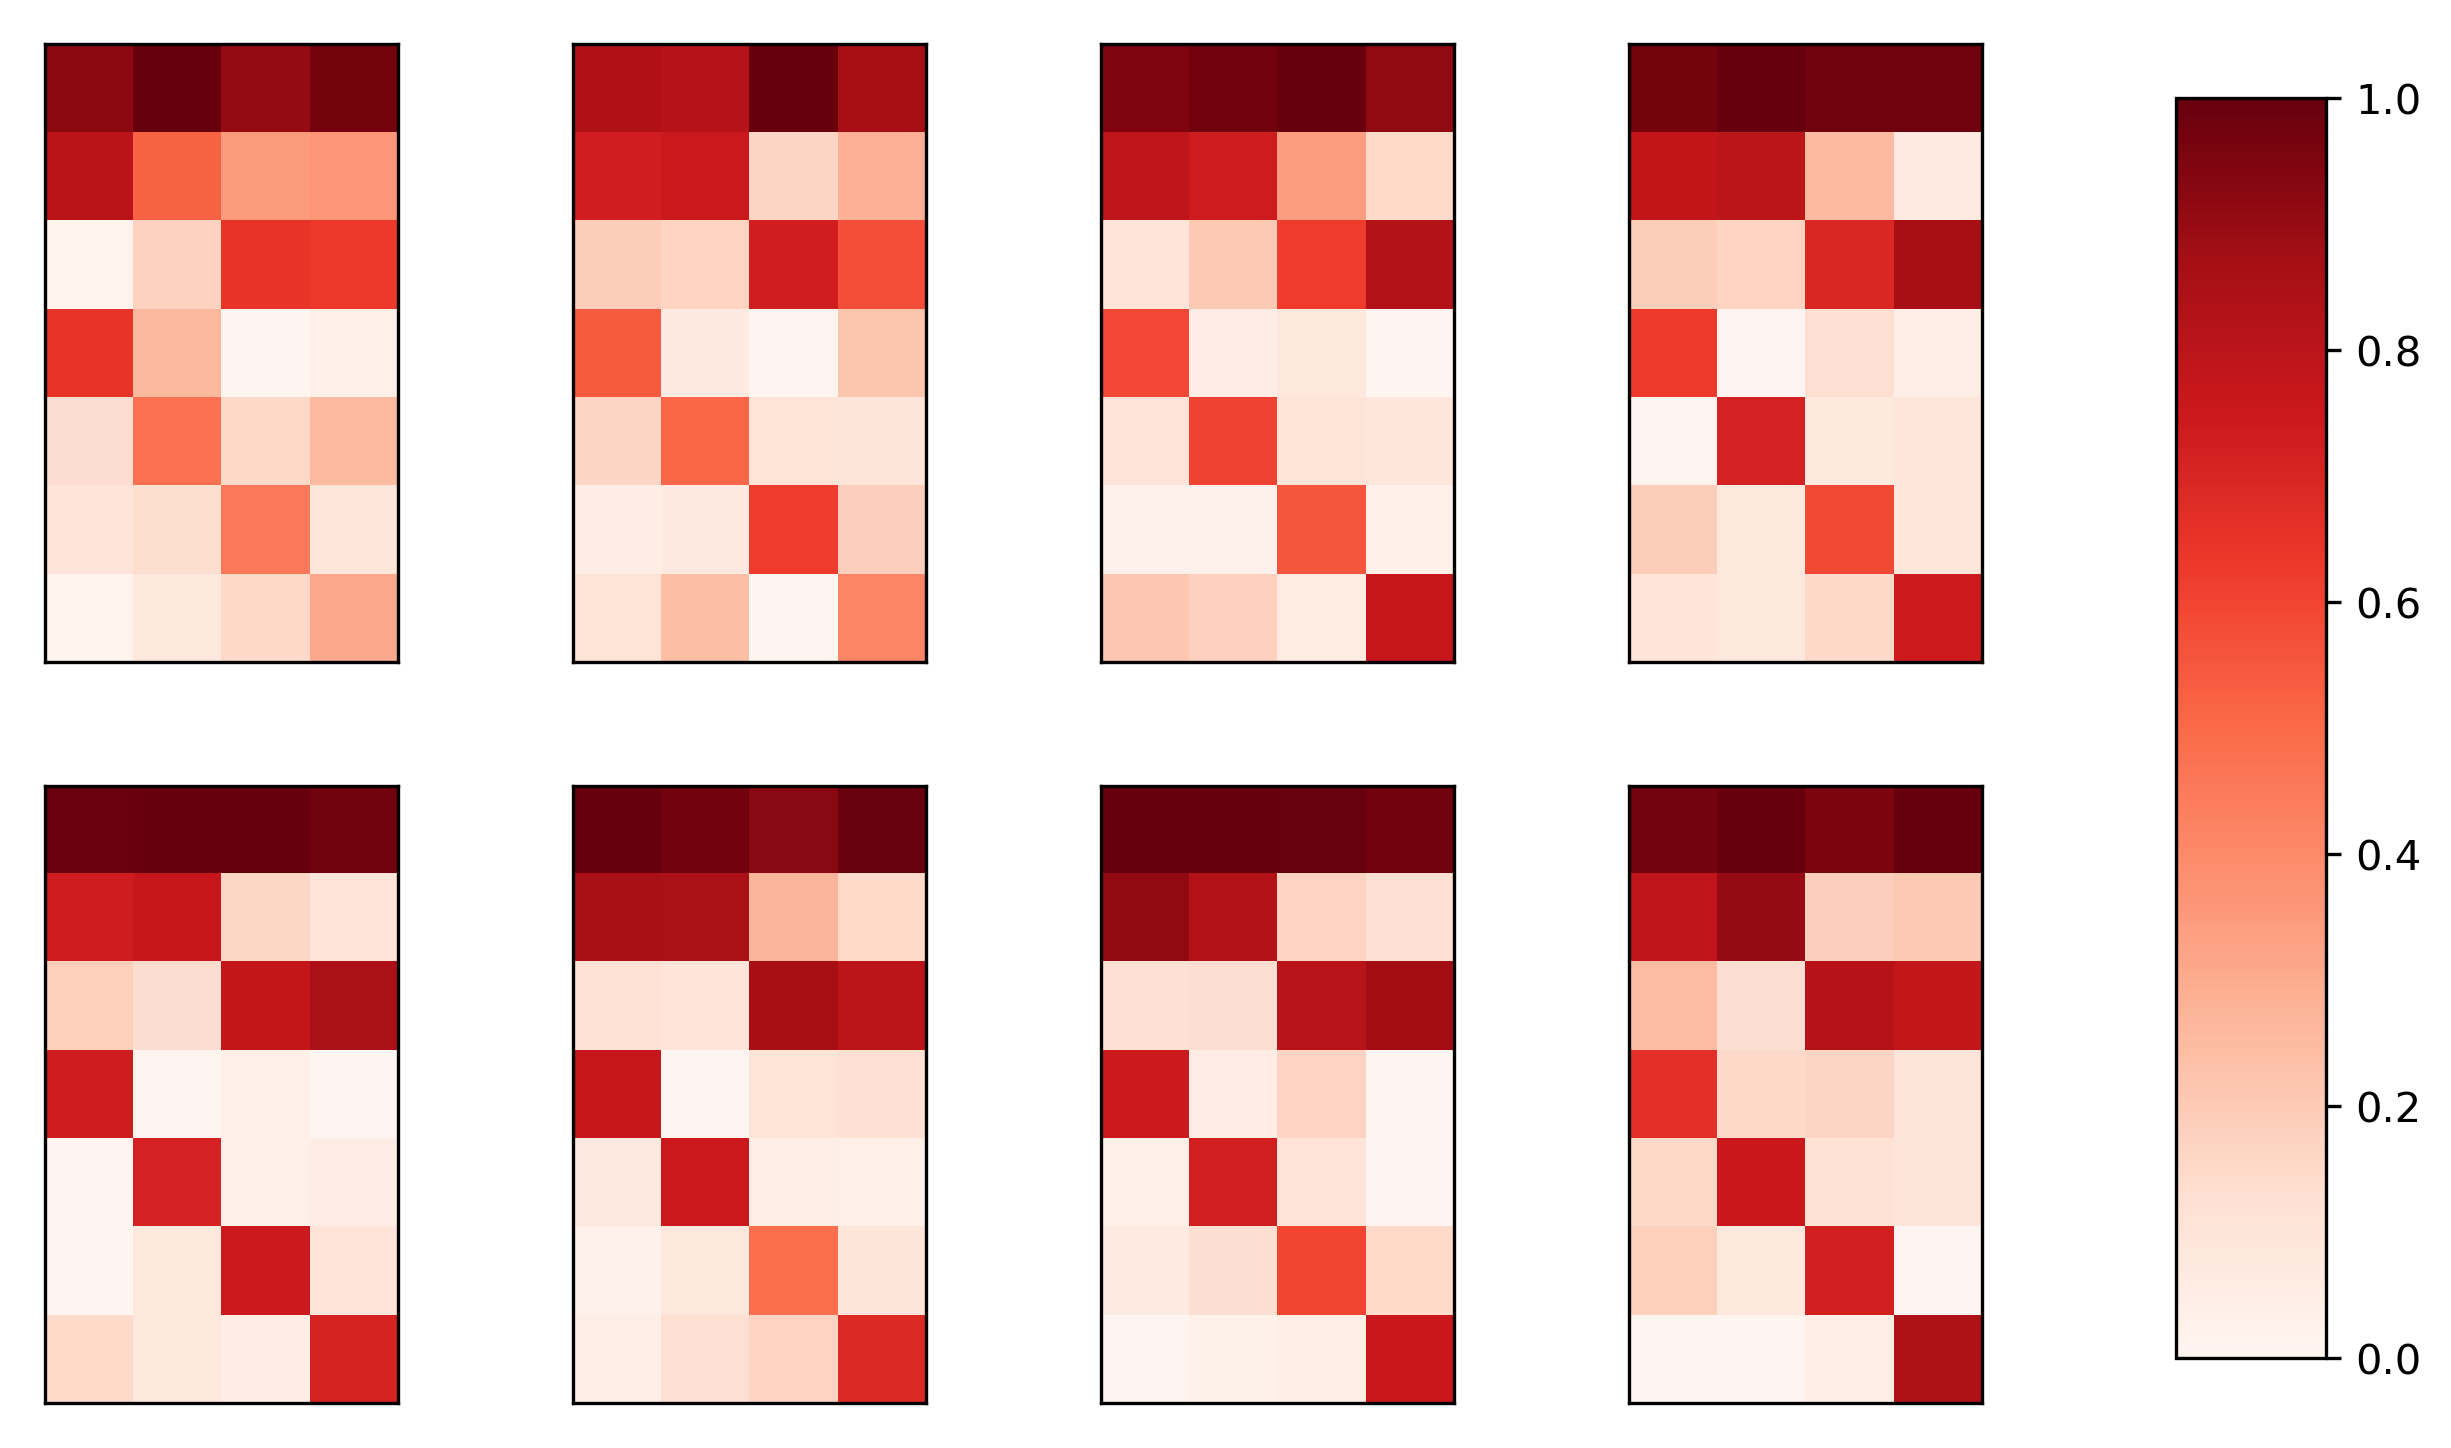

In [181]:
plot_inout_matrix(in_out_matrix, "test", "test")